# Reference bias using expected vs observed # of bases with no coverage

* https://www.illumina.com/documents/products/technotes/technote_coverage_calculation.pdf
* https://en.wikipedia.org/wiki/DNA_sequencing_theory#Early_uses_derived_from_elementary_probability_theory
* http://seqanswers.com/forums/showpost.php?p=161353&postcount=2

The problem can be boiled down to the following question: given sequence coverage $\lambda$, the proportion of sites with no coverage can be modelled as a probability that $Poisson(\lambda) = 0$. Under ideal conditions and infinite number of sites, the proportion of sites with no coverage should be exactly equal to this value.

What is the proportion of sites with no coverage in our samples? Are there differences between Neanderthal and Denisovan samples? Keep in mind that both _Denisova 4_ and _Denisova 8_ have almost the same TMRCA, significantly different from all other Neanderthals, who also give the same TMRCA values.

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(glue)
library(here)
library(rtracklayer)
library(GenomicRanges)
library(cowplot)
library(lemon)
})

devtools::load_all(".")

Loading ychr



In [2]:
cov_df <- readRDS(here("data/rds/cov_df.rds"))

In [3]:
samples <- unique(cov_df$name)

In [4]:
samples

[1] "Denisova 4"              "Denisova 8"             
 [3] "Spy 94a"                 "Mezmaiskaya 2"          
 [5] "El Sidrón 1253 (118 kb)" "El Sidrón 1253 (560 kb)"
 [7] "A00-1"                   "A00-2"                  
 [9] "A00"                     "S_BedouinB-1"           
[11] "S_Burmese-1"             "S_Dai-2"                
[13] "S_Dinka-1"               "S_Finnish-2"            
[15] "S_French-1"              "S_Gambian-1"            
[17] "S_Han-2"                 "S_Ju_hoan_North-1"      
[19] "S_Karitiana-1"           "S_Mandenka-1"           
[21] "S_Mbuti-1"               "S_Papuan-2"             
[23] "S_Punjabi-1"             "S_Saami-2"              
[25] "S_Sardinian-1"           "S_Thai-1"               
[27] "S_Turkish-1"             "S_Yoruba-2"             
[29] "Ust'-Ishim"              "mez2_dp1"               
[31] "mez2_dp10"               "mez2_dp2"               
[33] "mez2_dp3"                "mez2_dp4"               
[35] "mez2_dp5"                "mez2_dp6"               
[37] "mez2_dp7"                "mez2_dp8"               
[39] "mez2_dp9"                "Mezmaiskaya 2 (shotgun)"
[41] "Spy 94a (shotgun)"       "den_merged"             
[43] "Spy 94a (merged)"

In [5]:
avg_cov <- cov_df %>%
    filter(!str_detect(name, "merged")) %>% 
    group_by(name) %>%
    summarise(avg_coverage = mean(coverage)) %>%
    filter(!str_detect(name, "a00_|Ust")) %>%
    arrange(avg_coverage)

In [6]:
avg_cov <- avg_cov %>%
    mutate(observed_zero = round(map_dbl(name, ~ mean(filter(cov_df, name == .x)$coverage == 0)), 5),
           expected_zero = round(dpois(x = 0, lambda = avg_coverage), 5),
           difference = observed_zero - expected_zero) %>%
    mutate(data = case_when(
        str_detect(name, "S_|A00") ~ "shotgun (modern)",
        str_detect(name, "shotgun|Ust'-Ishim") ~ "shotgun (ancient)",
        TRUE ~ "capture"
))

In [7]:
avg_cov %>%
    filter(!str_detect(name, "A00-|mez2_dp")) %>%
    arrange(-abs(difference))

name,avg_coverage,observed_zero,expected_zero,difference,data
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Denisova 8,3.4820355,0.09555,0.03074,0.06481,capture
Spy 94a,0.8253622,0.49341,0.43808,0.05533,capture
Denisova 4,1.3717806,0.30622,0.25365,0.05257,capture
El Sidrón 1253 (118 kb),3.2121215,0.08978,0.04027,0.04951,capture
El Sidrón 1253 (560 kb),7.9165032,0.04479,0.00036,0.04443,capture
Mezmaiskaya 2,14.3494002,0.03561,0.00000,0.03561,capture
Spy 94a (shotgun),0.5052873,0.61337,0.60333,0.01004,shotgun (ancient)
Mezmaiskaya 2 (shotgun),0.8248822,0.44174,0.43829,0.00345,shotgun (ancient)
S_Yoruba-2,16.9616115,0.00129,0.00000,0.00129,shotgun (modern)


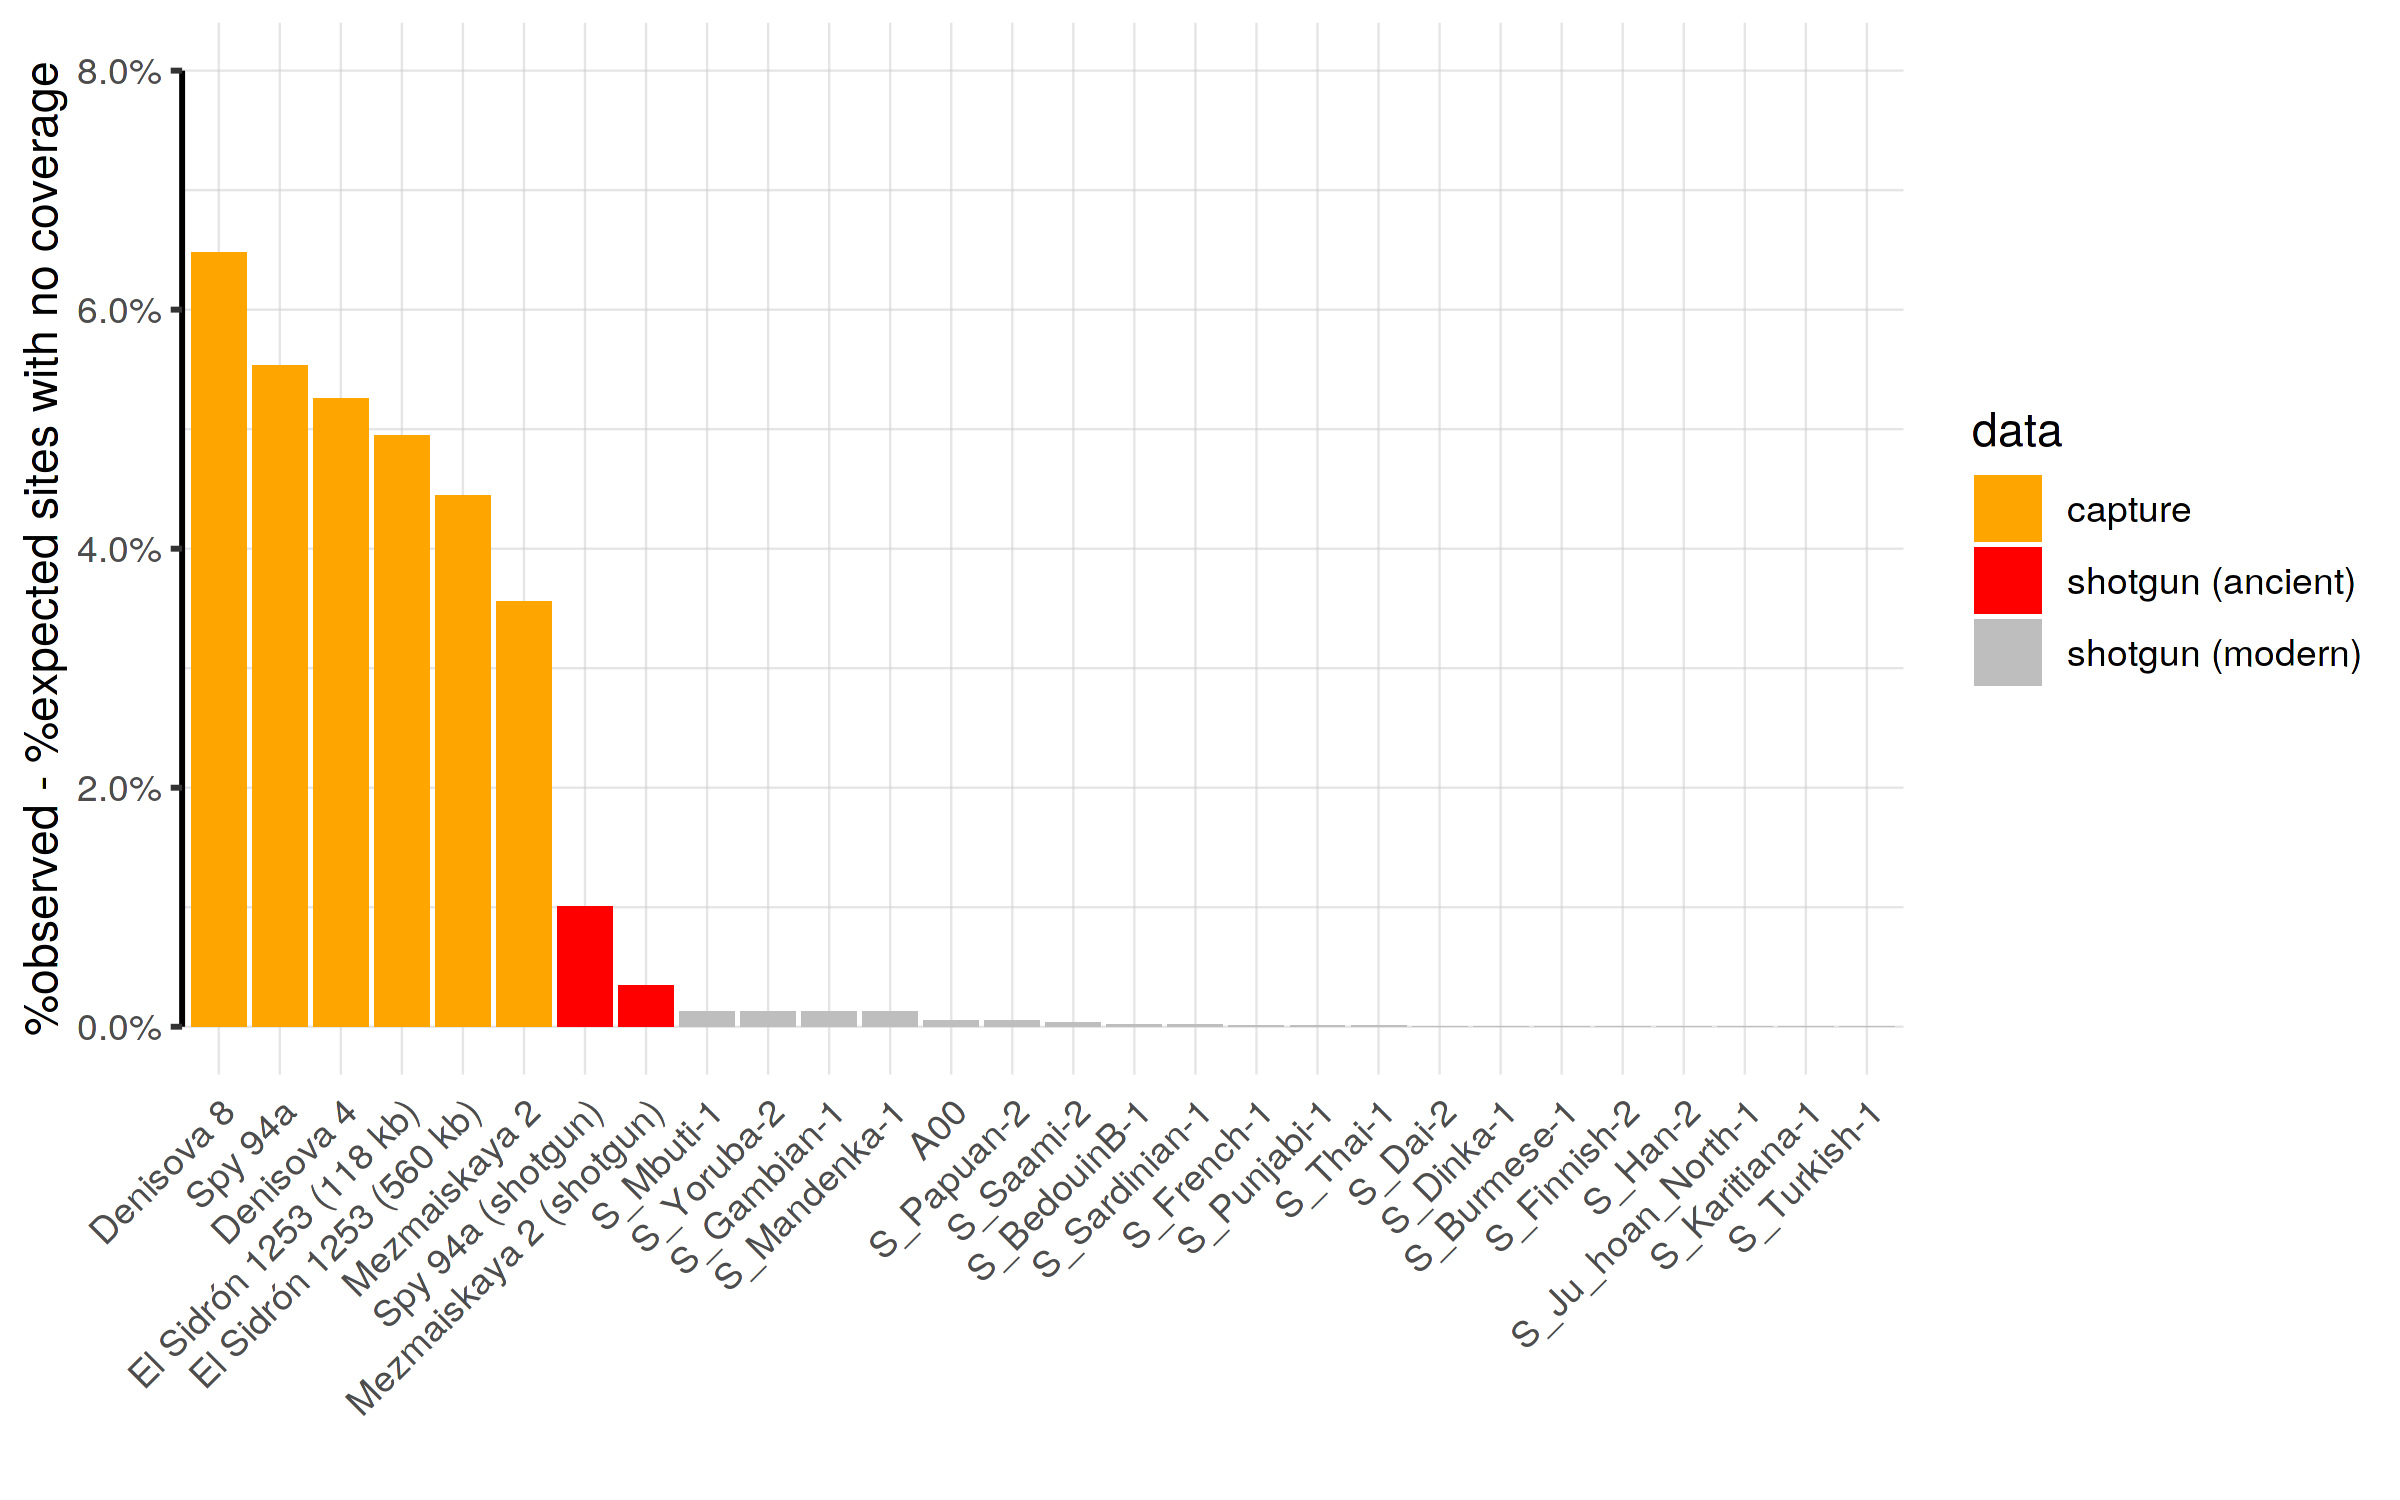

In [8]:
set_dim(8, 5)

filter(avg_cov, !str_detect(name, "A00-|mez2_dp")) %>%
    ggplot(aes(fct_reorder(name, abs(difference), .desc = TRUE), difference, fill = data)) +
    geom_bar(stat = "identity") +
    xlab("") + ylab("%observed - %expected sites with no coverage") +
    theme_classic() +
    theme(
        axis.text.x = element_text(hjust = 1, angle = 45),
        panel.border = element_blank(), 
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    background_grid(
        major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2,
        color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
        color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)
    ) +
    coord_capped_cart(left = "both") +
    scale_y_continuous(limits = c(0, 0.08), labels = scales::percent) +
    scale_fill_manual(values = c("orange", "red", "gray"))